# A-Symmetric QNN for binary classification of Schwinger model states
The following notebook contains parts of the code in the results presented at the Superconducting Qubits and Algorithms(SQA) conference 2023 in the poster **Symmetrizing Quantum Machine Learning for Quantum Field Theory**. 

In particular the notebook presents the implementation for a QNN without symmetries in order to classify states of the Schwinger Model. The Notebook is divided in the following sections:
- Dataset Creation
- Circuit Building
- Circuit Training
- Plots

In [1]:
import numpy as np
import pennylane as qml
import jax
import optax
import jax.numpy as jnp
from functools import partial

## Dataset Creation

Generation of the dataset containing the Schwinger lattices. `dataset_generator.py` contains the functions to both create a lattice, `generator`, and to calculate the Delta value, `Deltal_calculation`. See `dataset_generator.py` to visit the functions. Finally the dataset is divided into a train and test dataset.

In [2]:
symmetry = True
n_qubits = 8
threshold = 2

from dataset_generator import *

X = []
Y = []
np.random.seed(123)
for i in range(10000):
    v = list(generator(int(n_qubits/2),int(i%4)))
    if v in X:
        pass
    else:
        v = [int(v[j]) for j in range(len(v))]
        X.append(v)
        if Deltal_calculation(v)<threshold:
            Y.append(1)
        else:
            Y.append(-1)
print(Y.count(-1),Y.count(1))

24 45


The data is split into 70% train and 30% test dataset

In [20]:
np.random.seed(1234)
shuffle_indices = np.random.permutation(len(X))
train_size = int(len(X)*0.7)

train_indices = np.array(shuffle_indices[:train_size])
test_indices = np.array(shuffle_indices[train_size:])

x_train, y_train = np.take(X, train_indices, axis=0), np.take(Y, train_indices, axis=0)
x_test, y_test = np.take(X, test_indices, axis=0), np.take(Y, test_indices, axis=0)

x_train = jnp.array(x_train)
x_test = jnp.array(x_test)

for x,y in zip(x_train[:5, :], y_train[:5]):
    print(x,y)

[1 1 1 1 0 0 0 0] 1
[1 0 1 0 0 1 0 1] -1
[1 0 1 1 1 1 0 1] -1
[1 1 0 0 1 1 0 0] 1
[0 1 1 1 1 0 1 1] -1



## Circuit Building

The following sections of code create the QNN. The creation is divided into a series of function:
- `encode_data` - encodes the incoming data in a circuit
- `basic_ansatz_layer` - creates the basic ansatz of the QNN
- `basic_ansatz` - Repeats the ansatz given the amount of sublayers in the circuit
- `symmetry_output` - output of the QNN
- `circuit` - creates the QNN

Finally an exmaple of a circuit with 3 layers and 1 sublayer is shown.

In [5]:
def encode_data(x):
    '''
    x - A Schwinger lattice in binary representation as a list
    
    Perform a RX(pi) rotation is the lattice point is 1, 0 otherwise.
    '''  
    for i in np.arange(n_qubits):
        qml.RX(jnp.pi*x[i], wires=i)

def basic_ansatz_layer(thetas):
    '''
    thetas - Parameters of the QNN

    Creates the basic ansatz of the QNN. This is composed of a RX, RY and RZ rotation on each qubit, followed by C-Phase gates on neighbouring qubits.
    '''
    k = 0
    
    for i in range(n_qubits):
        qml.RX(thetas[i], wires=i)
    k+=n_qubits
    for i in range(n_qubits):
        qml.RY(thetas[i+k], wires=i)
    k+=n_qubits
    for i in range(n_qubits):
        qml.RZ(thetas[i+k], wires=i)
    k+=n_qubits

    for i in range(0,int(n_qubits/2)):
        qml.CPhase(thetas[i+k], wires=[2*i,2*i+1]) #
    k+=int(n_qubits/2)
    for i in range(0,int(n_qubits/2)):
        qml.CPhase(thetas[i+k],wires=[2*i+1,(2*i+2)%n_qubits]) # 


def basic_ansatz(thetas,):
    '''
    thetas - Parameters of the QNN

    Applies the Anstaz to the circuit. A sublayer is composed by a repition of the ansatz.
    '''
    k = 0
    for lay in range(sublayers):
        basic_ansatz_layer(thetas[k:params_per_sublayer+k])
        k += params_per_sublayer

    
def symmetry_output(wires):
    '''
    wires - number of wires used in the circuit

    The output of the circuit, Z expectation value for each qubit.
    '''
    op_final = qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7))  
    return op_final

In [6]:
device = qml.device("default.qubit.jax", wires=n_qubits)
    
@qml.qnode(device,interface='jax')
def circuit(x, thetas):
    '''
    x - A Schwinger lattice in binary representation as a list
    thetas - Parameters of thn QNN

    Creates the entire circuit. A layer is composed of data encoding layer followed by a number of ansatz layers. A sublayer is formed by a repitition of the ansatz.
    '''
    j = 0
    for lay in range(layers):
        encode_data(x,)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
        basic_ansatz(thetas[j:j+(params_per_sublayer)*sublayers],)
        j += (params_per_sublayer)*sublayers
    qml.Barrier(wires=range(n_qubits),only_visual=True)

    return symmetry_output(wires=range(n_qubits))

(<Figure size 2016x648 with 1 Axes>, <Axes: >)

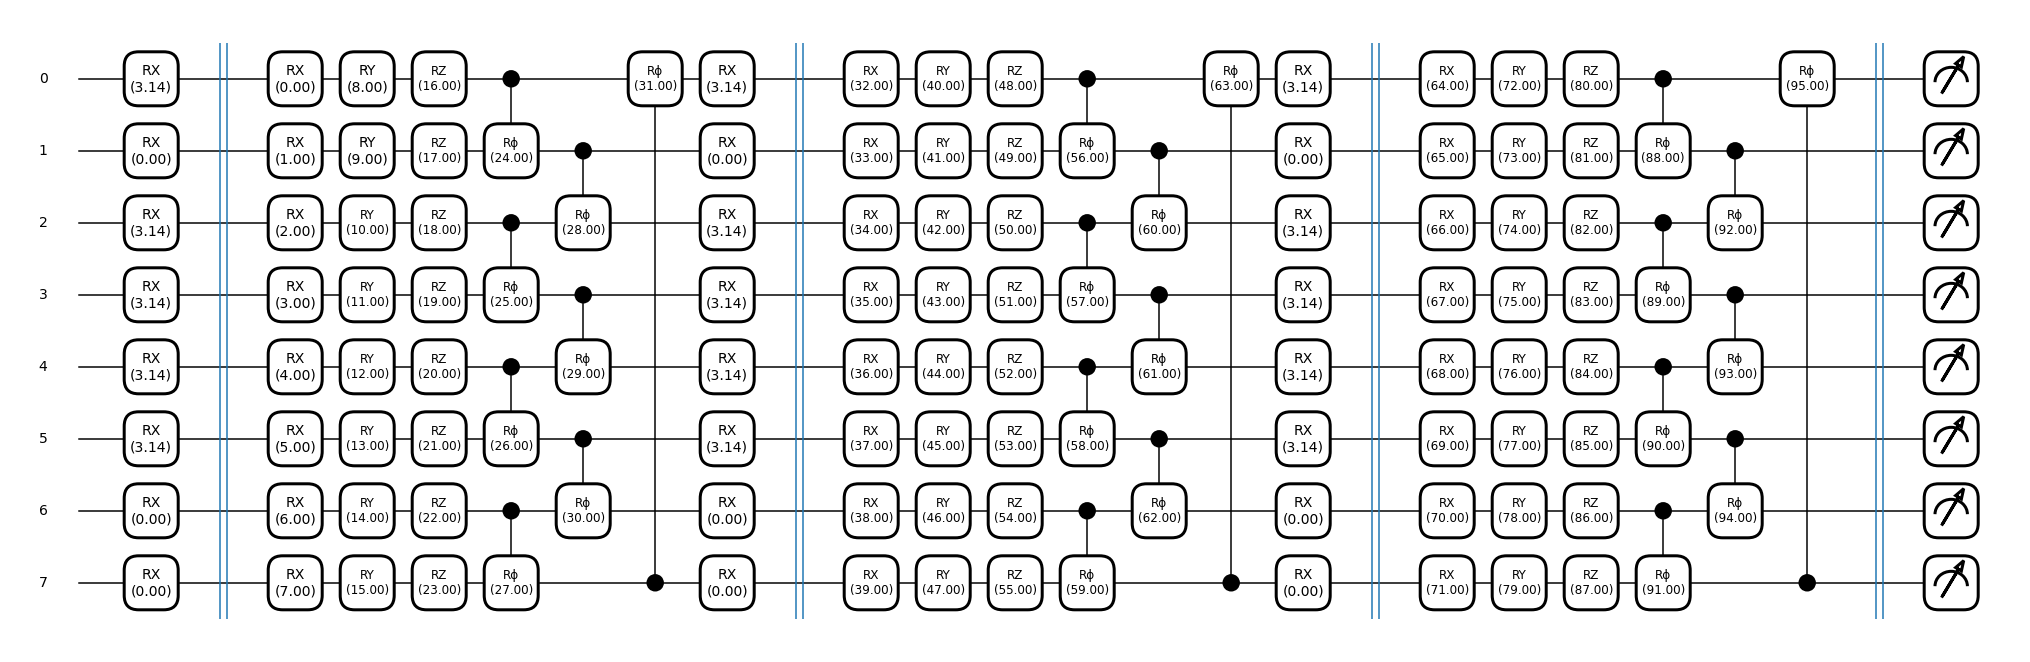

In [7]:
layers = 3
sublayers = 1
params_per_sublayer = 4*n_qubits
qml.draw_mpl(circuit, decimals=2,)([1,0,1,1,1,1,0,0],np.arange(params_per_sublayer*layers*sublayers),1,1)

## Circuit Training
This section takes care of training the QNN. The first section defines the cost, accuracy and optimizer update function. In particular:
- `calculate_mse_cost` - calculates the MSE cost
- `calculate_mse_cost_and_accuracy` - calculates the MSE cost and accuracy
- `optimizer_update` - Uses the MSE cost to update the parameters in the model according to the chosen optimizer.

Following this the training is performed using a set number of epochs and stocastic steps per epoch which are defined by the user. Each training loop consists of the calculation of the cost and parameter update using `optimizer_update`, followed by saving the cost and accuracy for both train and test dataset using `calculate_mse_cost_and_accuracy`.

In [8]:
@jax.jit
def calculate_mse_cost(X, y, theta):
    '''
    X - A Schwinger lattice in binary representation as a list
    y - The true label associated with X
    theta - Parameters of the QNN

    Calculates the MSE cost for a given data point and label.
    '''
    y = jnp.array(y)
    yp = qnn(X, theta,0,0) 
    cost = jnp.mean((yp - y) ** 2)#
    return cost

@jax.jit
def calculate_mse_cost_and_accuracy(X,y, theta,):
    '''
    X - A Schwinger lattice in binary representation as a list
    y - The true label associated with X
    theta - Parameters of the QNN

    Calculates both the MSE and the accuracy for a given data point
    '''
    y = jnp.array(y)
    yp = qnn(X, theta,0,0) 
    yp = jnp.array(yp)
    cost = jnp.mean((yp - y) ** 2)
    rounded = jnp.where(yp>0., 1, -1)
    
    return cost, sum(rounded==y)/X.shape[0]

# Optimization update step
@jax.jit
def optimizer_update(opt_state, params, x, y, ):
    '''
    opt_state - state of the optimizer
    params - Parameters of the QNN
    x - A Schwinger lattice in binary representation as a list
    y - The true label associated with X

    Calculates the MSE cost and updatez the parameters according to the chosen optimizer. 
    '''
    loss, grads = jax.value_and_grad(lambda theta: calculate_mse_cost(x, y, theta,))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [45]:
#Jax jit and vmap speed up the computational times of the circuit 
sublayers = 1
layers = 4
params_per_sublayer = 4*n_qubits 
qnn_batched = jax.vmap(circuit, (0, None, None, None))
qnn = jax.jit(qnn_batched)

In [46]:
#Parameter initialization
n_runs = 1
epochs = 800 
stoc_steps = 1
batch_size = x_train.shape[0] 
seed = 123

#Lists to save data 
costs_per_comb = []
test_costs_per_comb = []
opt_params_per_comb = []
costs = []
test_costs = []
train_accs = []
test_accs = []

#Creating the initial random parameters for the QNN
key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=((params_per_sublayer)*layers*sublayers,))
key = jax.random.split(key)[0]
params = jnp.copy(initial_params)

#Optimizer initialization
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(initial_params)

for epoch in range(epochs):
    for step in range(stoc_steps):
        # Generation of random indices to be used for stocastic step
        idxs = jax.random.choice(key, jnp.array(list(range(x_train.shape[0]))), shape=(batch_size,), replace=False)
        key = jax.random.split(key)[0]

        #Calculate cost function and update parameters accordingly
        params, opt_state, cost = optimizer_update(opt_state, params, x_train[idxs,:], y_train[idxs])

        #Save MSE Costs and accuracies for both train and test dataset
        cost, acc = calculate_mse_cost_and_accuracy(x_train, y_train,params)
        costs.append(cost)
        train_accs.append(acc)
        test_cost, test_acc = calculate_mse_cost_and_accuracy(x_test, y_test, params, )
        test_costs.append(test_cost)
        test_accs.append(test_acc)

    print(f"layers:{layers}, p:{sublayers}, epoch {epoch}/{epochs}",'--- Train cost:',cost,'--- Test cost:',test_cost, end='\r')

costs_per_comb.append(costs)
test_costs_per_comb.append(test_costs)
opt_params_per_comb.append(params)


## Plots
This section plots the results gathered after carrying a series of experiments for different QNN trained without symmetry. From the experiments there were 2 situations that occured: overfitting or inability to learn. 

For only 1 layer it was seen that the QNN was unable to learn any pattern in the data, resulting in a flat line for both the loss and the accuracy.  

For subsequent experiments, were the number of layers was increased, it was seen the the QNN did manage to learn using the training data but was unable to translate this onto the test data, making it possible to deduce that the model was suffering from overfitting. A possible explanation of the phenomena is due to the fact that each layer had a large number of parameters, 32, meaning the addition of a single layer could cause large problem in the training.  

In [48]:
import os

dir_path = '.'
data_folder_non_symm = dir_path+f'/asymmetric/{layers}l-{sublayers}p' 
os.makedirs(data_folder_non_symm,  0o755,  exist_ok=True)
np.save(data_folder_non_symm+'/train_cost.npy', list(costs))
np.save(data_folder_non_symm+'/test_cost.npy', list(test_costs))
np.save(data_folder_non_symm+'/train_accs.npy', list(train_accs))
np.save(data_folder_non_symm+'/test_accs.npy', list(test_accs))
np.save(data_folder_non_symm+'/opt_params.npy', list(params))

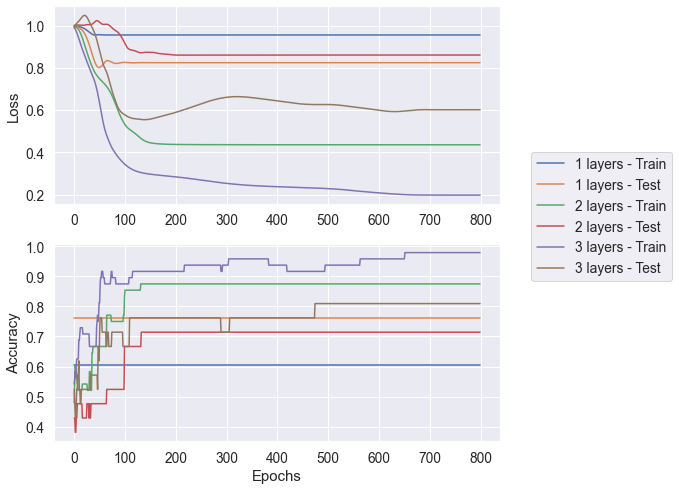

In [88]:
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline
sns.set(font_scale=1.25)

fig, ax = plt.subplots(2,1,figsize=(8,8))
for layers in range(1,4):
    sublayers = 1
    dir_path = '.'
    data_folder_non_symm = dir_path+f'/asymmetric/{layers}l-{sublayers}p' 
    test_cost_asymm = np.load(data_folder_non_symm+'/test_cost.npy', )
    train_cost_asymm = np.load(data_folder_non_symm+'/train_cost.npy', )


    ax[0].plot(train_cost_asymm, label=f'{layers} layers - Train')#
    ax[0].plot(test_cost_asymm, label=f'{layers} layers - Test')

ax[0].set_ylabel('Loss')
lgd = ax[0].legend(bbox_to_anchor=(1.4, 0.3), )

for layers in range(1,4):
    sublayers = 1
    dir_path = '.'
    data_folder_non_symm = dir_path+f'/asymmetric/{layers}l-{sublayers}p' 
    test_cost_asymm = np.load(data_folder_non_symm+'/test_accs.npy', )
    train_cost_asymm = np.load(data_folder_non_symm+'/train_accs.npy', )


    ax[1].plot(train_cost_asymm, label=f'{layers} layers - Train')#
    ax[1].plot(test_cost_asymm, label=f'{layers} layers - Test')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

fig.savefig('./asymmetric/loss_acc_asymm.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()